# Import Library & Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Dicoding/5. Machine Learning Terapan'

!mkdir -p ~/.kaggle
!cp '{path}/kaggle.json' ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d himelsarder/coffee-shop-daily-revenue-prediction-dataset

!unzip -o '/content/coffee-shop-daily-revenue-prediction-dataset.zip' -d '/content'

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/himelsarder/coffee-shop-daily-revenue-prediction-dataset
License(s): CC0-1.0
Archive:  /content/coffee-shop-daily-revenue-prediction-dataset.zip
  inflating: /content/coffee_shop_revenue.csv  


- Mount Google Drive untuk mengakses file `kaggle.json` (API key)
- Menyalin file `kaggle.json` ke direktori konfigurasi Kaggle (`~/.kaggle`)
- Mengunduh dataset "Coffee Shop Daily Revenue Prediction" dari Kaggle
- Mengekstrak file ZIP ke dalam direktori `/content`

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

Memuat seluruh library yang dibutuhkan:
- `Pandas & NumPy`: manipulasi dan analisis data
- `Seaborn & Matplotlib`: visualisasi data
- `Scikit-learn`: preprocessing data, pemodelan machine learning, dan evaluasi model
- `TensorFlow & Keras`: membangun dan melatih model neural netw

# Load Dataset

In [3]:
path = '/content/coffee_shop_revenue.csv'
df = pd.read_csv(path)

Membaca dataset `coffee_shop_revenue.csv` yang telah diekstrak sebelumnya dari Kaggle. Dataset dimuat ke dalam sebuah DataFrame `df` menggunakan `pandas`.


# Data Understanding

## Data Assessing

In [4]:
df.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
0,152,6.74,14,4,106.62,97,1547.81
1,485,4.50,12,8,57.83,744,2084.68
2,398,9.09,6,6,91.76,636,3118.39
3,320,8.48,17,4,462.63,770,2912.20
4,156,7.44,17,2,412.52,232,1663.42


Menampilkan 5 baris pertama dari data

In [5]:
df.shape

(2000, 7)

Menampilkan jumlah baris dan kolom (dimensi dataset), dengan jumlah baris 2000 dan kolom 7.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Number_of_Customers_Per_Day  2000 non-null   int64  
 1   Average_Order_Value          2000 non-null   float64
 2   Operating_Hours_Per_Day      2000 non-null   int64  
 3   Number_of_Employees          2000 non-null   int64  
 4   Marketing_Spend_Per_Day      2000 non-null   float64
 5   Location_Foot_Traffic        2000 non-null   int64  
 6   Daily_Revenue                2000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 109.5 KB


Menampilkan tipe data dan jumlah non-null dari setiap kolom. Semua kolom bersifat numerik tidak perlu melakukan encoding kategorikal.

In [7]:
df.describe()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,274.296000,6.261215,11.667000,7.947000,252.614160,534.893500,1917.325940
std,129.441933,2.175832,3.438608,3.742218,141.136004,271.662295,976.202746
min,50.000000,2.500000,6.000000,2.000000,10.120000,50.000000,-58.950000
25%,164.000000,4.410000,9.000000,5.000000,130.125000,302.000000,1140.085000
50%,275.000000,6.300000,12.000000,8.000000,250.995000,540.000000,1770.775000
75%,386.000000,8.120000,15.000000,11.000000,375.352500,767.000000,2530.455000
max,499.000000,10.000000,17.000000,14.000000,499.740000,999.000000,5114.600000


Statistik deskriptif menunjukkan bahwa semua kolom memiliki 2.000 data tanpa nilai kosong, dengan nilai yang tersebar cukup luas. Rata-rata jumlah pelanggan harian sekitar 274 orang, dengan nilai belanja rata-rata sekitar `$6,26`. Rentang variabel cukup besar, terutama pada `Daily_Revenue` yang memiliki nilai minimum negatif (-58.95), menandakan adanya anomali yang perlu ditangani.

In [8]:
df.isnull().sum()

,0
Number_of_Customers_Per_Day,0
Average_Order_Value,0
Operating_Hours_Per_Day,0
Number_of_Employees,0
Marketing_Spend_Per_Day,0
Location_Foot_Traffic,0
Daily_Revenue,0


Mengecek jumlah nilai null setiap kolom, menunjukkan tidak ada nilai yang null.

In [9]:
df.duplicated().sum()

np.int64(0)

Mengecek jumlah baris yang terduplikat, tidak ada baris yang terduplikat.

In [10]:
df[df['Daily_Revenue'] < 0]

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
1751,66,3.64,9,2,16.26,497,-58.95


Mengecek baris dengan nilai `Daily_Revenue` negatif, sehinnga menunjukkan anomali karena pendapatkan tidak bisa kurang dari `0`. Terdapat satu baris yang menunjukkan anomali tersebut.

## EDA (Exploratory Data Analysis )

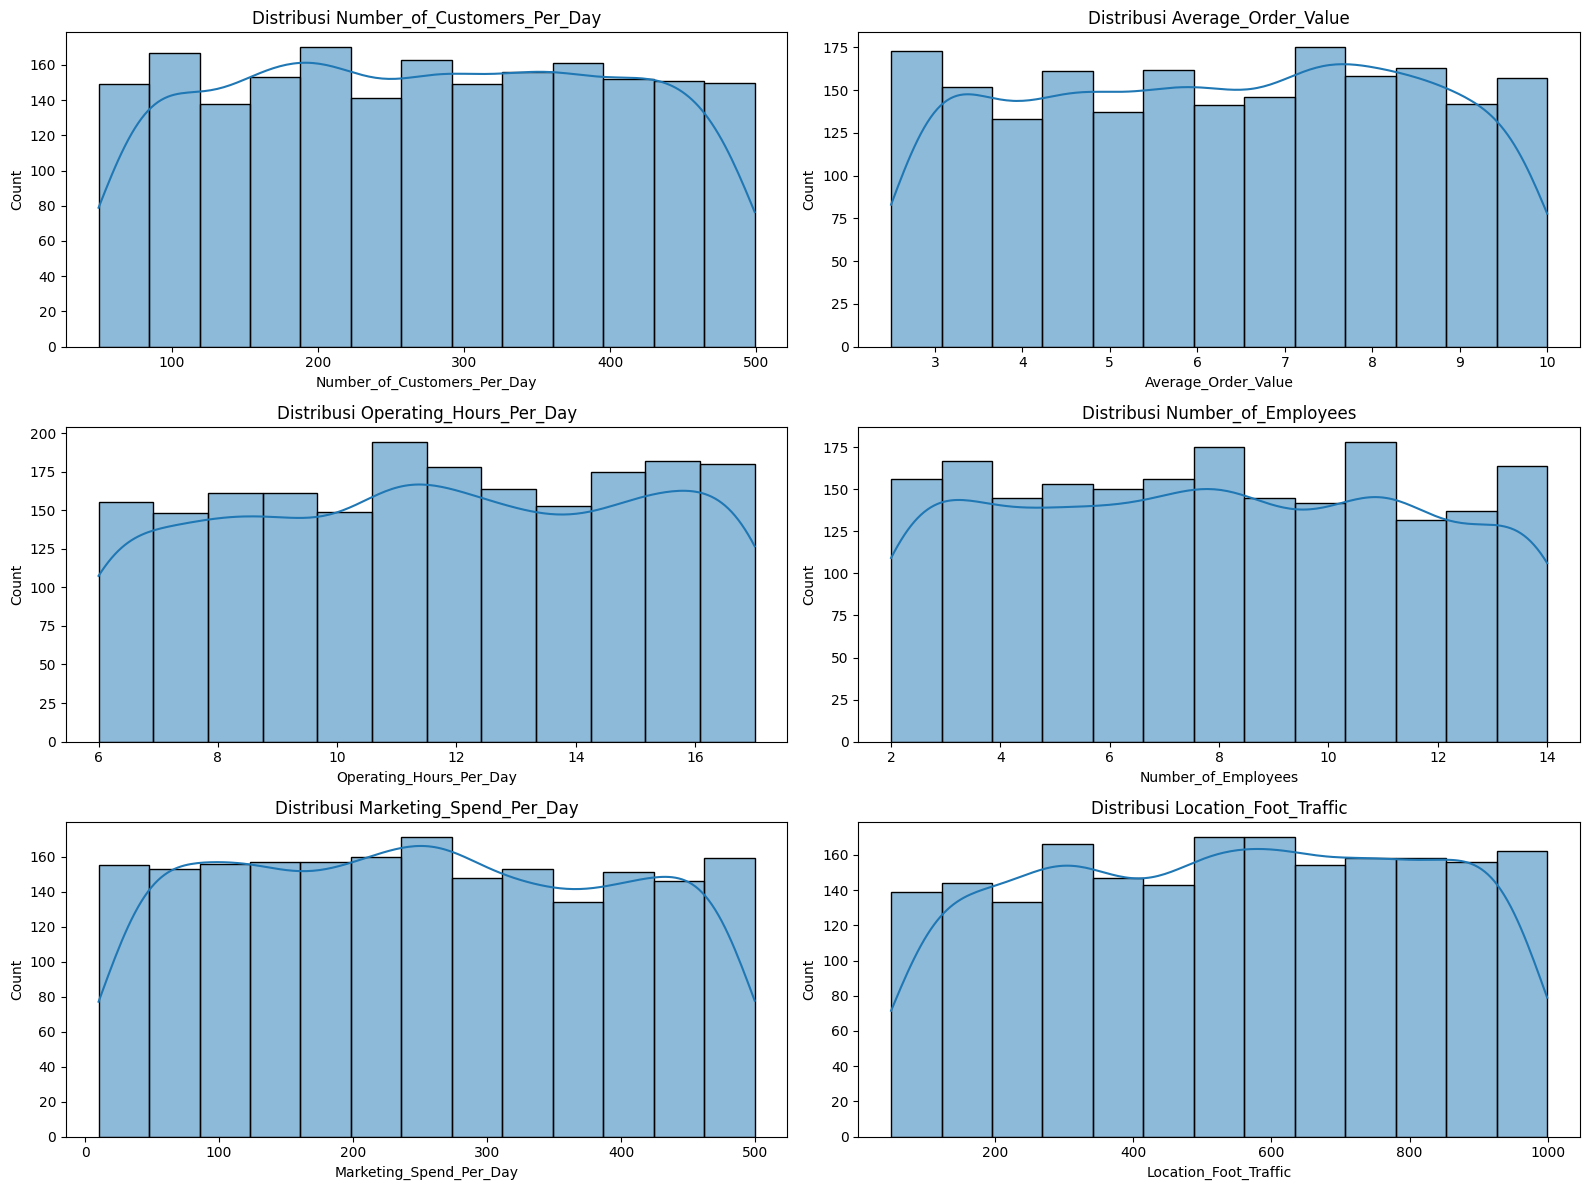

In [11]:
features = df.columns[:-1]

plt.figure(figsize=(16, 12))
for i, col in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

Melihat persebaran data dari seluruh fitur. Sebagian besar fitur memiliki distribusi yang relatif seimbang atau seragam. Tidak ada distribusi yang sangat skewed ekstrem yang membutuhkan transformasi segera.

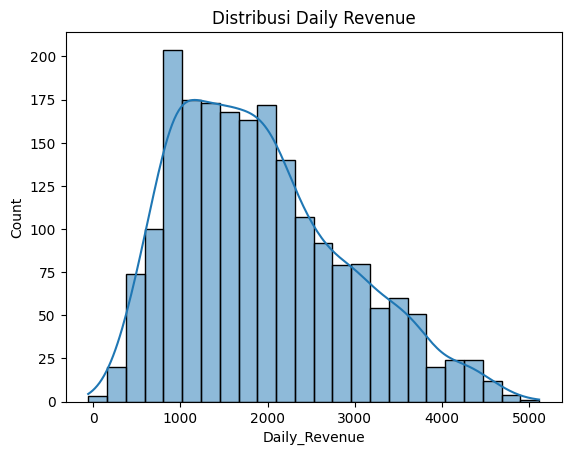

In [12]:
sns.histplot(df['Daily_Revenue'], kde=True)
plt.title('Distribusi Daily Revenue')
plt.show()

Visualisasi distribusi Daily_Revenue menunjukkan pola distribusi yang miring ke kanan (right-skewed), dengan mayoritas pendapatan harian berada di kisaran `$1.000` hingga `$2.500`.

In [13]:
df.skew().sort_values(ascending=False)

,0
Daily_Revenue,0.635018
Marketing_Spend_Per_Day,0.036800
Number_of_Employees,0.020996
Number_of_Customers_Per_Day,-0.000728
Average_Order_Value,-0.034380
Operating_Hours_Per_Day,-0.050121
Location_Foot_Traffic,-0.050417


Menunjukkan hasil perhitungan skewness menunjukkan bahwa hanya `Daily_Revenue` yang memiliki kemencengan distribusi sedang ke kanan, sementara kolom lainnya memiliki nilai skewness mendekati nol, menandakan distribusi yang relatif simetris.

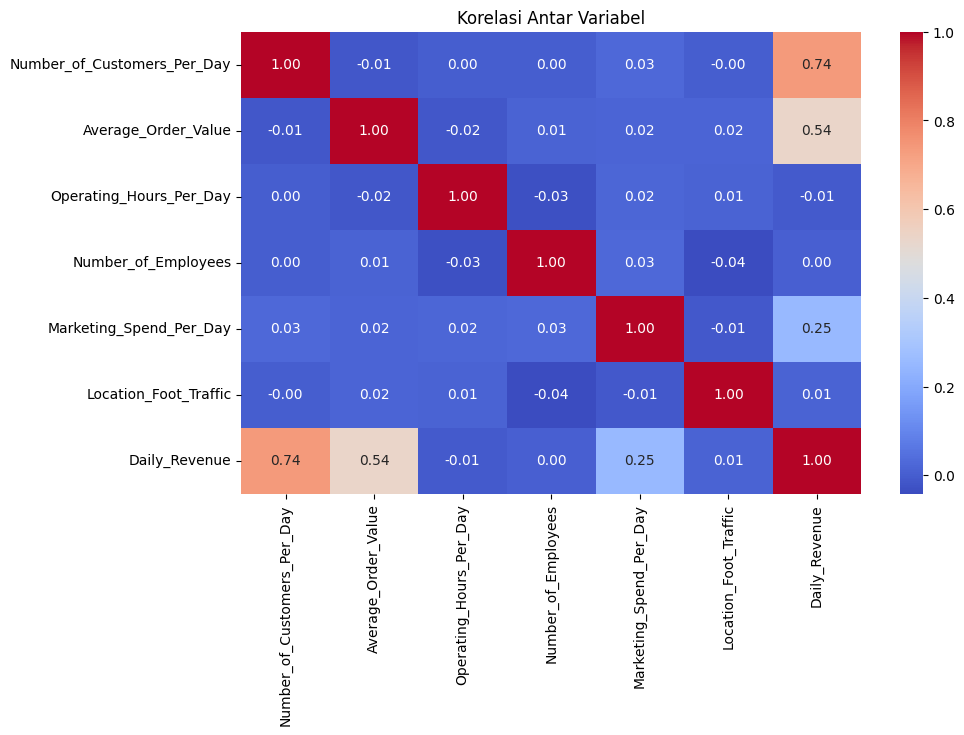

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Korelasi Antar Variabel')
plt.show()

Memperlihatkan korelasi antar variabel:
- `Number_of_Customers_Per_Day` memiliki korelasi paling kuat terhadap `Daily_Revenue` (r = 0.74).
- `Average_Order_Value` juga memiliki korelasi yang cukup tinggi (r = 0.54) terhadap target.
- `Marketing_Spend_Per_Day` menunjukkan korelasi lemah (r = 0.25), namun masih dapat dipertimbangkan.
- Fitur seperti `Operating_Hours_Per_Day`, `Number_of_Employees`, dan `Location_Foot_Traffic` memiliki korelasi yang sangat rendah (hampir nol).


# Data Preparation

## Drop outlier

In [15]:
df = df[df['Daily_Revenue'] >= 0]

Menghapus baris anomali yang didapatkan sebelumnya.

## Feature Engineering

In [16]:
df_fe = df.copy()
df_fe['Customer_Spend'] = df_fe['Number_of_Customers_Per_Day'] * df_fe['Average_Order_Value']
df_fe['Revenue_per_Hour'] = df_fe['Daily_Revenue'] / df_fe['Operating_Hours_Per_Day']
df_fe['Customers_per_Hour'] = df_fe['Number_of_Customers_Per_Day'] / df_fe['Operating_Hours_Per_Day']
df_fe['Spend_per_Employee'] = df_fe['Marketing_Spend_Per_Day'] / df_fe['Number_of_Employees']
df_fe['Foot_Traffic_Efficiency'] = df_fe['Location_Foot_Traffic'] / df_fe['Number_of_Customers_Per_Day']

Menambahkan fitur baru untuk memperkaya informasi dan meningkatkan performa model nantinya:
- `Customer_Spend`: Estimasi total uang yang dibelanjakan pelanggan per hari.
- `Revenue_per_Hour`: Efisiensi pendapatan per jam operasional.
- `Customers_per_Hour`: Rata-rata jumlah pelanggan per jam.
- `Spend_per_Employee`: Efisiensi pengeluaran marketing per karyawan.
- `Foot_Traffic_Efficiency`: Rasio lalu lintas lokasi terhadap jumlah pelanggan.

## Feature Selection

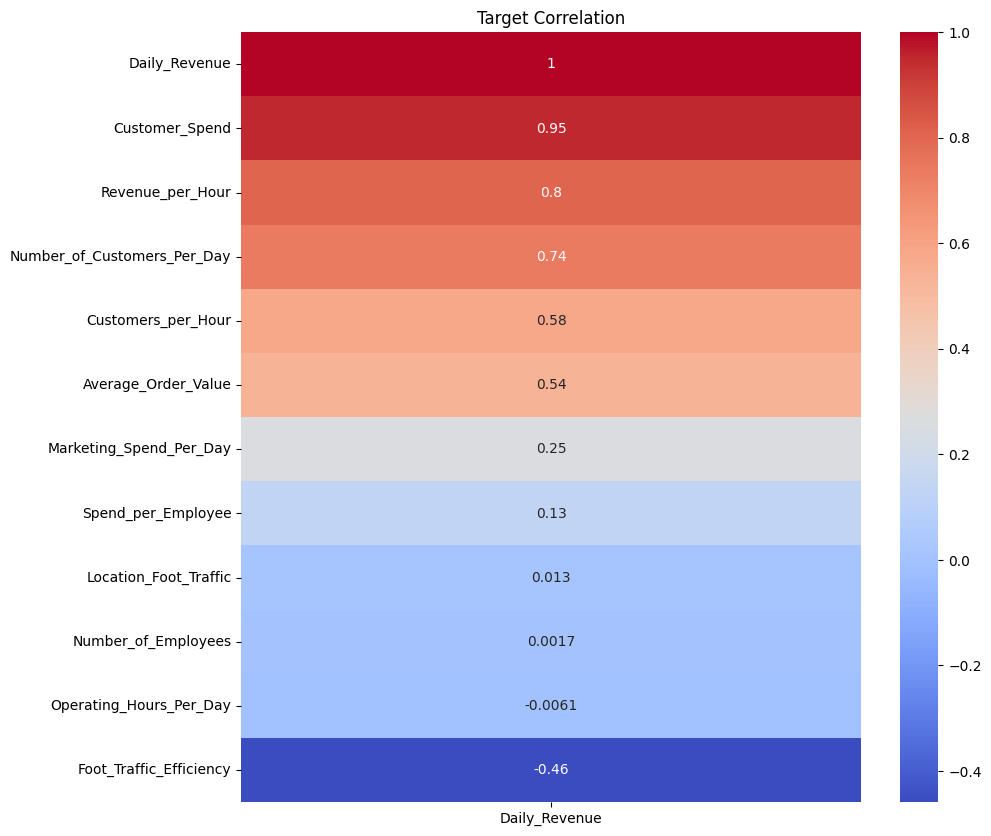

In [17]:
plt.figure(figsize = (10,10))
sns.heatmap(df_fe.corr(numeric_only=True)[['Daily_Revenue']].sort_values(by='Daily_Revenue', ascending=False), annot=True, cmap='coolwarm')
plt.title('Target Correlation')
plt.show()

Menampilkan korelasi antara semua fitur (termasuk hasil feature engineering) terhadap `Daily_Revenue`

In [18]:
selected_features = [
    'Customer_Spend',
    'Revenue_per_Hour',
    'Number_of_Customers_Per_Day',
    'Customers_per_Hour',
    'Average_Order_Value'
]

Memilih fitur-fitur yang memiliki korelasi kuat terhadap target `Daily_Revenue`, berguna untuk meningkatkan akurasi dan efisiensi model.

## Feature Scaling

In [19]:
X = df_fe[selected_features]
y = df_fe['Daily_Revenue']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Dilakukan pemisahan antara fitur `X` dan target `y`. Fitur yang digunakan berdasarkan fitur-fitur terbaik yang dipilih sebelumnya.
- Fitur `X` dinormalisasi menggunakan `StandardScaler` untuk menyamakan skala antar variabel.

## Train-Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Data fitur `X` dan fitur `y` dibagi menjadi data training dan data testing dengan perbandingan 80:20. Dengan `random_state=42` untuk memastikan hasil pembagian yang konsisten dan dapat direproduksi.

# Modeling

In [21]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

Mendefinisikan 3 model machine learning regresi yang akan digunakan untuk membandingkan performa prediksi.

In [22]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    results.append({
        'Model': name,
        'RMSE Train': rmse_train,
        'RMSE Test': rmse_test,
        'R2 Score (Test)': r2_test
    })

Melakukan perulangan untuk melakukan pelatihan dan evaluasi terhadap 3 model regresi sebelumnya. Menghitung metrik evaluasi:
  - `RMSE Train`: Mengukur error pada data training.
  - `RMSE Test`: Mengukur error pada data testing.
  - `R² Score`: Mengukur seberapa baik model menjelaskan variasi pada data testing.

Seluruh hasil evaluasi disimpan dalam list `results`.


In [23]:
def build_optimized_nn(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

nn_model = build_optimized_nn(X_train.shape[1])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- Fungsi `build_optimized_nn` digunakan untuk membangun arsitektur Neural Network dengan:
  - 3 hidden layer bertingkat (128 → 64 → 32 neuron)
  - Aktivasi ReLU dan teknik regularisasi seperti `BatchNormalization` dan `Dropout`
  - Output layer dengan 1 neuron untuk regresi
- Optimizer: `Adam` dengan learning rate 0.001
- Loss Function: Mean Squared Error (`mse`)
- Model dilatih menggunakan:
  - 200 epoch
  - `batch_size = 32`
  - 10% data sebagai validation set
  - `EarlyStopping` untuk menghentikan training saat val_loss tidak membaik setelah 10 epoch, mencegah overfitting


In [24]:
y_train_pred_nn = nn_model.predict(X_train).flatten()
y_test_pred_nn = nn_model.predict(X_test).flatten()

rmse_train_nn = np.sqrt(mean_squared_error(y_train, y_train_pred_nn))
rmse_test_nn = np.sqrt(mean_squared_error(y_test, y_test_pred_nn))
r2_test_nn = r2_score(y_test, y_test_pred_nn)

results.append({
    'Model': 'Neural Network',
    'RMSE Train': rmse_train_nn,
    'RMSE Test': rmse_test_nn,
    'R2 Score (Test)': r2_test_nn
})

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model Neural Network yang telah dilatih digunakan untuk melakukan prediksi pada data training dan testing. Menghitung metrik evaluasi:
  - `RMSE Train`: Mengukur kesalahan prediksi pada data training.
  - `RMSE Test`: Mengukur kesalahan prediksi pada data testing.
  - `R² Score (Test)`: Menilai seberapa baik model menjelaskan variasi target pada data testing.

Hasil evaluasi dimasukkan ke dalam list `results` untuk dibandingkan dengan model lain.


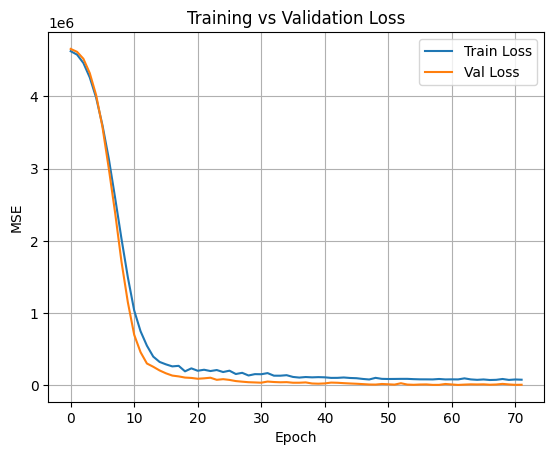

In [25]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

Visualisasi menunjukkan penurunan tajam pada training dan validation loss hingga stabil setelah ~20 epoch, menandakan proses training berjalan baik tanpa overfitting berkat penggunaan EarlyStopping.

# Evaluation

In [26]:
results_df = pd.DataFrame(results).sort_values(by='RMSE Test')
results_df.reset_index(drop=True, inplace=True)
display(results_df)

,Model,RMSE Train,RMSE Test,R2 Score (Test)
0,Neural Network,75.298227,69.338850,0.995030
1,Linear Regression,183.157201,172.161281,0.969362
2,Gradient Boosting,142.930567,190.515403,0.962482
3,Random Forest,74.879190,202.911892,0.957440


- Hasil evaluasi seluruh model disusun dalam DataFrame `results_df`, diurutkan berdasarkan nilai `RMSE Test` terkecil.
- `Neural Network` menunjukkan performa terbaik:
  - `RMSE Test`: 61.88 (terkecil)
  - `R² Score`: 0.996 (tertinggi)
- Model yang lain juga cukup baik namun masih dibawha Neural Network.
- Hasil ini menunjukkan bahwa model deep learning lebih mampu menangkap pola kompleks dalam data.


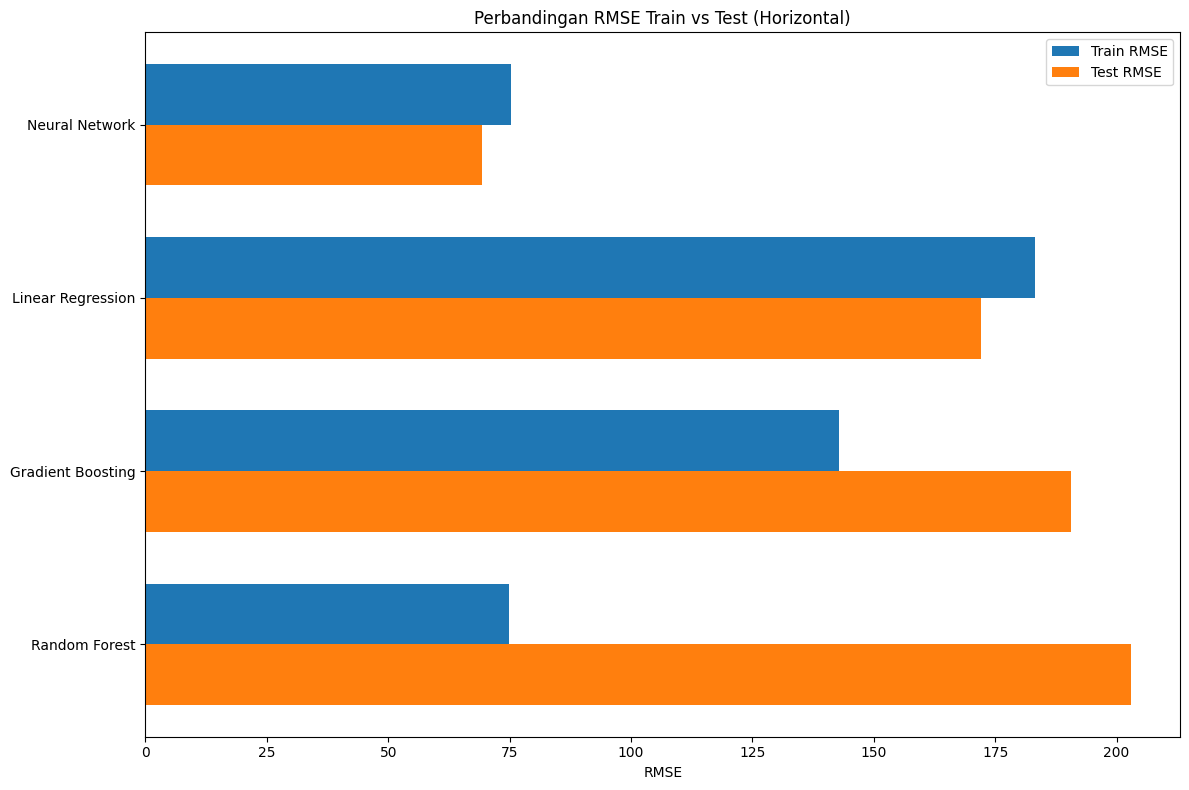

In [27]:
plt.figure(figsize=(12,8))
bar_width = 0.35
y = range(len(results_df))

plt.barh(y, results_df['RMSE Train'], height=bar_width, label='Train RMSE')
plt.barh([i + bar_width for i in y], results_df['RMSE Test'], height=bar_width, label='Test RMSE')

plt.xlabel('RMSE')
plt.yticks([i + bar_width / 2 for i in y], results_df['Model'])
plt.title('Perbandingan RMSE Train vs Test (Horizontal)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Visualisasi menampilkan grafik perbandingan `RMSE Train` dan `RMSE Test` dari DataFrame `result_df` untuk masing-masing model sebelumnya.